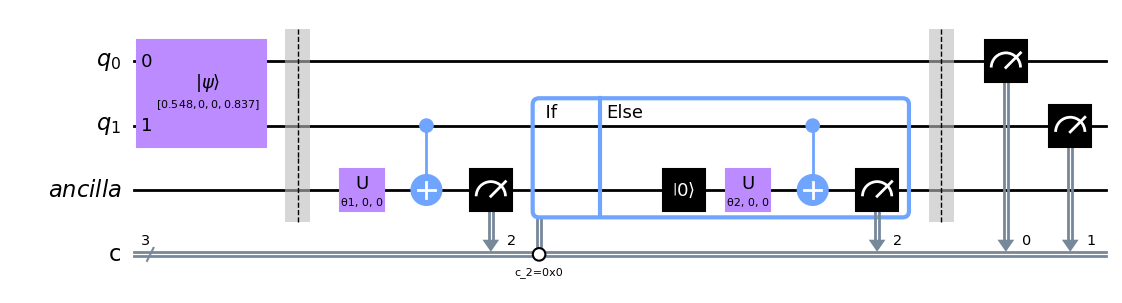

In [73]:
###Purification with CNOT and measurement error:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

q = QuantumRegister(2, 'q')
anc = QuantumRegister(1, 'ancilla')
c = ClassicalRegister(3, 'c')
qc = QuantumCircuit(q, anc, c)

# Specify the values of alpha and beta
alpha = np.sqrt(0.3)  # Replace with your desired alpha value
beta = np.sqrt(1 - alpha**2)   # Calculate beta based on alpha

# Apply the custom state preparation
qc.initialize([alpha, 0, 0, beta], [q[0], q[1]])
qc.barrier()

# Employing measurement on the second qubit (the qubit which is going to be sent through amplitude damping channel)
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')
theta3 = Parameter('θ3')
theta4 = Parameter('θ4')
theta5 = Parameter('θ5')

# First round of measurement
qc.u(theta1,0,0,anc[0])
qc.cx(1, 2)
qc.measure(2,2)

 
#Second round of measurement
with qc.if_test((c[2], 0)) as else_:
    pass
with else_:
    qc.reset(2)
    qc.u(theta2,0,0,anc[0])
    qc.cx(1, 2)
    qc.measure(2,2)
'''  
    # Third round of measurement
    with qc.if_test((c[2], 0)) as else_:
        pass
    with else_:
        qc.reset(2)
        qc.u(theta3,0,0,anc[0])
        qc.cx(1, 2)
        qc.measure(2,2)   
     
        # Fourth round of measurement
        with qc.if_test((c[2], 0)) as else_:
            pass
        with else_:
            qc.reset(2)
            qc.u(theta4,0,0,anc[0])
            qc.cx(1, 2)
 '''
qc.barrier()


error_rate_value=0.025
#Depolarizing error of CNOT gate:
error_rate =0# Adjust this value based on the desired error rate

# Create a depolarizing error for the CNOT gate
cnot_error = depolarizing_error(error_rate, 2)

# Specify the qubits for the error (in this case, qubits 0 and 1)
error_qubits = [1, 2]

# Create a noise model and add the CNOT error to it for the specified qubits
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', error_qubits)

# Add custom readout error model to the existing noise model
eta= error_rate_value# Adjust this value based on the desired readout error rate
error_meas_ancilla = ReadoutError([[1- eta, eta], [eta, 1- eta]])
noise_model.add_readout_error(error_meas_ancilla, [2]) 


qc.measure([0,1],[0,1])
# Plot the circuit
qc.draw('mpl')


In [74]:
# Calculate theta_value
theta1_value=2 * np.arctan(alpha/beta)
theta2_value=2 * np.arctan(alpha**2/beta**2)
theta3_value=2 * np.arctan(alpha**4/beta**4)
theta4_value=2 * np.arctan(alpha**8/beta**8)
theta5_value=2 * np.arctan(alpha**16/beta**16)

# Bind the parameter
#bound_qc = qc.bind_parameters({theta1: theta1_value, theta2: theta2_value, theta3: theta3_value})
bound_qc = qc.bind_parameters({theta1: theta1_value,theta2: theta2_value})
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")

job = backend.run(bound_qc, method=method,noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'111': 40038, '000': 28597, '011': 29763, '100': 1602}


C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_10760\3439834937.py:10: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_qc = qc.bind_parameters({theta1: theta1_value,theta2: theta2_value})


success: 58360 , fail: 41640 , total: 100000
Bell states counts: {'000': 28597, '011': 29763}
Bell new: {'00': 28597, '11': 29763}
probability of success 0.5836
fidelity 1.0


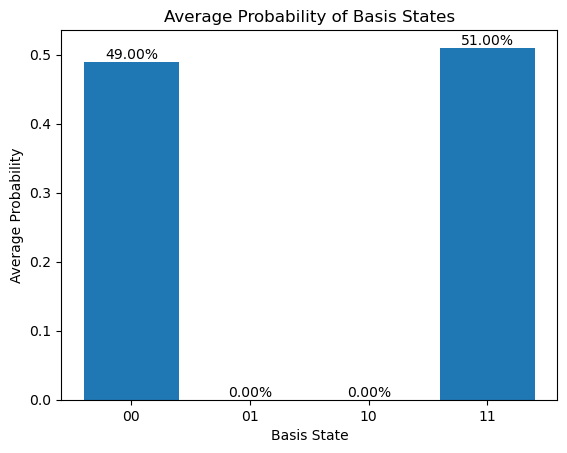

In [75]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
Psi=0
for jj in counts:
        if (jj[0]=='0'):
            success += counts[jj]
            if(jj[1]==jj[2]):
                Psi += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[1:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
print('Bell states counts:', Bell_states)
print('Bell new:', Bell_new)
print('probability of success',success/total)
#print('fidelity',0.5 * (1 + Psi / success))
# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
#probabilities = [Bell_new.get(state, 0) / Shots_n for state in basis_states] # Un-normalized state
prob_00 = probabilities[basis_states.index('00')]
prob_11 = probabilities[basis_states.index('11')]
entropy=4*prob_00*prob_11
#print('entropy:',entropy)
print('fidelity',Psi/success)
# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
#plt.title(f'Average Probability of Basis States (alpha^2={alpha**2})')
plt.title(f'Average Probability of Basis States')

for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()